# Introduction to Sentiment Analysis

Sentiment analysis is an approach in natural language processing (NLP) used to determine the sentiment expressed in a text, such as a sentence or social media post. It aims to classify the text as positive, negative, or neutral, revealing the writer's opinion or emotional state.

Neural networks, specifically recurrent neural networks (RNNs) and convolutional neural networks (CNNs), are widely used for sentiment analysis due to their ability to capture intricate patterns and relationships in data. The sentiment analysis process using neural networks typically involves the following steps:

1. **Data Preparation**: Collect or prepare a dataset with labeled examples of text and their corresponding sentiment labels. Preprocess the dataset by tokenizing the text, removing stopwords, and performing any necessary preprocessing steps.

2. **Word Embeddings**: Convert the text data into numerical representations suitable for neural networks. Word embeddings, such as Word2Vec or GloVe, map words to continuous vectors, capturing semantic relationships.

3. **Neural Network Architecture**: Design a neural network architecture suitable for sentiment analysis. RNNs, like LSTM or GRU, capture contextual information and word dependencies. CNNs, adapted for text analysis, capture local patterns and feature combinations.

4. **Training**: Split the labeled dataset into training and validation sets. Feed the training data into the neural network and optimize its parameters using an appropriate optimization algorithm, such as stochastic gradient descent.

5. **Evaluation**: Assess the trained model's performance on the validation or test set using metrics like accuracy, precision, recall, and F1 score.

6. **Fine-tuning and Hyperparameter Optimization**: Refine the model by adjusting its architecture, hyperparameters, or training process based on evaluation results. This iterative process enhances the model's performance.

7. **Inference**: Apply the trained model to predict sentiment in new, unseen text data. The model takes input text, applies preprocessing steps, and produces a sentiment prediction (positive, negative, or neutral).

This project utilizes a dataset available [here](https://www.kaggle.com/c/tweet-sentiment-extraction/overview), comprising approximately 20k tweets. Let's begin by importing the required modules:

In [1]:
import numpy as np
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow's INFO and WARNING messages
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)  # Suppress TensorFlow's ERROR messages

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
import re

import keras
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.callbacks import ModelCheckpoint

# Data Visualization

The dataset can be loaded as follows:

In [2]:
train = pd.read_csv('./dataset.csv')

train.head(15)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


As can be seen, 3 kinds of sentiments can be found in the dataset:
1. Positive
2. Neutral
3. Negative

In [3]:
# Check what the unique values are
train['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

# Data Pre-processing
A general pre-processing procedure can be summarized with the following steps:
1. **Filtering**: This is done by removing URLs and email addresses as these elements don't provide meaningful value for sentiment analysis. Additionally, also punctuation is removed, thus treating "good!" and "good" as the same sentiment, for instance.
2. **Lowercase all text**: Standardizing the text to lowercase helps make the input more consistent. This ensures that phrases like "Good" at the beginning of a sentence are not interpreted differently from "good" elsewhere.

3. **Remove stop-words**: Stop-words are commonly used words in a language that add noise and do not contribute to the overall sentiment. Removing them helps make the data more meaningful.

4. **Stemming/Lemmatizing** (optional): Stemming and lemmatizing are techniques to extract the root words from sentences. Stemming often shortens words, while lemmatizing returns valid words.

5. **Transform text into numeric tensors**: Deep learning models require numeric tensors as input, so the text data needs to be converted. This process, known as vectorization, is essential. For traditional machine learning models, options like CountVectorizer, TFIDF Vectorizer, or Bag-Of-Words can be used.


The general structure of the dataset can be modified selecting only the needed columns. The null values are filled with a "No content" sentence:

In [4]:
train = train[['selected_text','sentiment']]
train["selected_text"].fillna("No content", inplace = True)
train.head()

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


The data can now be filtered using the following function:

In [5]:
def filter_data(input_data):
    # Remove URLs using regular expression
    url = re.compile(r'https?://\S+|www\.\S+')
    input_data = url.sub(r'', input_data)

    # Remove email addresses
    input_data = re.sub('\S*@\S*\s?', '', input_data)

    # Remove new line characters
    input_data = re.sub('\s+', ' ', input_data)

    # Remove distracting single quotes
    input_data = re.sub("\'", "", input_data)
        
    return input_data

In [6]:
# Applying the filter
filtered = [filter_data(text) for text in train['selected_text'].values.tolist()]

list(filtered[:5])

['I`d have responded, if I were going',
 'Sooo SAD',
 'bullying me',
 'leave me alone',
 'Sons of ****,']

Converting sentences to words:

In [7]:
data_words = [gensim.utils.simple_preprocess(str(sentence), deacc=True) for sentence in filtered]

print(data_words[:5])

[['have', 'responded', 'if', 'were', 'going'], ['sooo', 'sad'], ['bullying', 'me'], ['leave', 'me', 'alone'], ['sons', 'of']]


This can now be detokenized:

In [8]:
data = [TreebankWordDetokenizer().detokenize(text) for text in data_words]

print(data[:5])

['have responded if were going', 'sooo sad', 'bullying me', 'leave me alone', 'sons of']


Finally, the pre-processing is complete. As can be seen, the initial noisy text has been transformed into a plain and simple one.

# Word Embedding

It is essential to understand a crucial step when working with text data. Once the text data is free from unnecessary elements, the next task is to convert it into floating-point tensors. This conversion is achieved using word embeddings.

**Word embeddings**, also known as word vectors, are learned from data and are essentially low-dimensional floating-point vectors that contain condensed information. They are different from sparse vectors obtained through methods like one-hot encoding. The reason for using word embeddings is that deep learning models tend to perform better and converge more easily with dense vectors. However, the choice of using word embeddings depends on the nature of the dataset and the specific requirements of the project.

There are two ways to obtain word embeddings:

1. Using a pre-trained word embedding stack integrated into the model, similar to incorporating a pre-trained neural network layer. However, this approach is not commonly used.

2. Learning word embeddings from scratch. This involves starting with random word vectors and progressively learning meaningful ones, similar to how a neural network learns its weights. This option allows for the creation of a new embedding space for each unique task. Fortunately, implementing word embeddings in TensorFlow or Keras is a straightforward process. It can be treated as an additional layer within the neural network structure.

In the following code cell, the sentiment labels are mapped to their corresponding numerical values:

In [9]:
labels = np.array(train['sentiment'])
label_mapping = {'neutral': 0, 'negative': 1, 'positive': 2}
y = np.array([label_mapping[label] for label in labels])
labels = tf.keras.utils.to_categorical(y, num_classes=3, dtype="float32")

The data must now be sequenced and split. Firstly, the text is transformed into 3D float data, in this way the neural networks can be trained on it:

In [10]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)

print(tweets)

[[   0    0    0 ...   68  146   41]
 [   0    0    0 ...    0  397   65]
 [   0    0    0 ...    0    0   11]
 ...
 [   0    0    0 ...  372   10    3]
 [   0    0    0 ...   24  542    4]
 [   0    0    0 ... 2424  199  657]]


The dataset can now be split in train and test datasets:

In [11]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, random_state=0)
print("Train length", len(X_train), "- Test length:", len(X_test))

Train length 20610 - Test length: 6871


# Model building

Three different kinds of Recurrent Neural Networks (RNN) have been explored. Sequential models from the Keras API were used to achieve this task. The following networks will be analyzed:

1. **Long Short-Term Memory** (LSTM) Network
2. **Bidirectional LSTM** Network
3. **Convolutional 1D** Network

## Single LSTM layer model

The following code snippet represents a single LSTM layer model.

In this code, an **embedding layer** is added to convert integer-encoded words into dense vectors of fixed size (20 in this case).

A **single LSTM layer** with 15 units is then added to the model. The LSTM layer processes the sequential input data and captures relevant patterns and dependencies. The ***dropout*** parameter of 0.5 specifies that during training, 50% of the LSTM units will be randomly set to 0 at each update to prevent overfitting.

Finally, a **3-unit output layer** is connected. The output layer produces probabilities for each of the three possible classes, indicating the model's predicted class probabilities. In order to make probabilistic outputs, it’s always good to use ***softmax*** as activation function in the final layer.

In [12]:
# Build model
single_lstm = Sequential()
single_lstm.add(layers.Embedding(max_words, 20))
single_lstm.add(layers.LSTM(15, dropout=0.5))
single_lstm.add(layers.Dense(3, activation='softmax'))

# Compile model
single_lstm.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Init model checkpoins
checkpoint_single = ModelCheckpoint("best_single_lstm.hdf5", monitor='val_accuracy', verbose=0, save_best_only=True, mode='auto', save_freq='epoch', save_weights_only=False)

# Save history
history_single_lstm = single_lstm.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[checkpoint_single])

Epoch 1/10
645/645 [==============================] - 46s 68ms/step - loss: 0.8182 - accuracy: 0.6456 - val_loss: 0.6775 - val_accuracy: 0.7436
Epoch 2/10
645/645 [==============================] - 45s 70ms/step - loss: 0.6001 - accuracy: 0.7637 - val_loss: 0.5389 - val_accuracy: 0.7890
Epoch 3/10
645/645 [==============================] - 47s 74ms/step - loss: 0.5129 - accuracy: 0.7996 - val_loss: 0.4939 - val_accuracy: 0.8131
Epoch 4/10
645/645 [==============================] - 47s 73ms/step - loss: 0.4773 - accuracy: 0.8142 - val_loss: 0.4772 - val_accuracy: 0.8194
Epoch 5/10
645/645 [==============================] - 50s 77ms/step - loss: 0.4535 - accuracy: 0.8276 - val_loss: 0.4704 - val_accuracy: 0.8213
Epoch 6/10
645/645 [==============================] - 49s 76ms/step - loss: 0.4361 - accuracy: 0.8358 - val_loss: 0.4584 - val_accuracy: 0.8206
Epoch 7/10
645/645 [==============================] - 48s 74ms/step - loss: 0.4252 - accuracy: 0.8389 - val_loss: 0.4594 - val_accuracy:

## Bidirectional LTSM model

The bidirectional layer enhances the order sensitivity of recurrent neural networks (RNNs) by **combining two RNNs**, such as LSTMs or GRUs, which process the input sequence in different directions and subsequently merge their representations. This approach enables the bidirectional layer to capture more intricate patterns compared to a single RNN layer. Essentially, one of the layers interprets the sequences in chronological order, while the second layer does so in the opposite, or anti-chronological, order. This utilization of bidirectional RNNs has gained widespread popularity due to their ability to deliver superior performance compared to regular RNNs.

In [13]:
# Build model
bi_lstm = Sequential()
bi_lstm.add(layers.Embedding(max_words, 40, input_length=max_len))
bi_lstm.add(layers.Bidirectional(layers.LSTM(20, dropout=0.6)))
bi_lstm.add(layers.Dense(3, activation='softmax'))

# Compile model
bi_lstm.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Init model checkpoins
checkpoint_bi = ModelCheckpoint("best_bi_lstm.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', save_freq='epoch', save_weights_only=False)

# Save history
history_bi = bi_lstm.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[checkpoint_bi])

Epoch 1/10
645/645 [==============================] - ETA: 0s - loss: 0.7829 - accuracy: 0.6574
Epoch 1: val_accuracy improved from -inf to 0.74574, saving model to best_bi_lstm.hdf5
645/645 [==============================] - 56s 83ms/step - loss: 0.7829 - accuracy: 0.6574 - val_loss: 0.6158 - val_accuracy: 0.7457
Epoch 2/10
645/645 [==============================] - ETA: 0s - loss: 0.5591 - accuracy: 0.7762
Epoch 2: val_accuracy improved from 0.74574 to 0.78024, saving model to best_bi_lstm.hdf5
645/645 [==============================] - 54s 84ms/step - loss: 0.5591 - accuracy: 0.7762 - val_loss: 0.5369 - val_accuracy: 0.7802
Epoch 3/10
645/645 [==============================] - ETA: 0s - loss: 0.4984 - accuracy: 0.8053
Epoch 3: val_accuracy improved from 0.78024 to 0.80949, saving model to best_bi_lstm.hdf5
645/645 [==============================] - 53s 83ms/step - loss: 0.4984 - accuracy: 0.8053 - val_loss: 0.4870 - val_accuracy: 0.8095
Epoch 4/10
645/645 [==========================

The achieved performance is quite satisfactory, even when considering the simplicity of the model and the lack of specific efforts to fine-tune the hyperparameters. By making targeted adjustments, even more significant outcomes can be obtained. However, it's important to recognize that there is no secret formula for optimizing the model. The key lies in refining the model's structure to enhance its ability to comprehend intricate patterns effectively, while also addressing the challenge of overfitting through regularization techniques.

An essential point to highlight is that if you observe the model's accuracy or loss reaching a plateau, it is likely because of a low learning rate, which causes the optimizer to get stuck in a local minimum of the loss function. In such instances, increasing the learning rate or trying an alternative optimizer can help overcome this limitation.

## 1D Convolutional model

This model is recognized for its fast convergence and low computational requirements. However, it is important to mention that, based on previous experience, this specific model tends to fit excessively to small datasets.

The model utilizes similar principles as classical 2D Convolutional Neural Networks (ConvNets) commonly used for image classification. Specifically, the convolutional layers in this model extract patches from tensors of varying dimensions based on the task and layer. These layers then apply consistent convolutional transformations to each patch, resulting in multiple subsequences as output.

The remarkable aspect of these convolutional layers is their ability to detect patterns within a sequence. Notably, a pattern learned at one position in a sentence can be recognized at a different position within the same sentence or even in another sentence. This characteristic emphasizes the effectiveness of convolutional layers in capturing and understanding sequential patterns.

In [14]:
# Build model
conv1D_model = Sequential()
conv1D_model.add(layers.Embedding(max_words, 40, input_length=max_len))
conv1D_model.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3), bias_regularizer=regularizers.l2(2e-3)))
conv1D_model.add(layers.MaxPooling1D(5))
conv1D_model.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3), bias_regularizer=regularizers.l2(2e-3)))
conv1D_model.add(layers.GlobalMaxPooling1D())
conv1D_model.add(layers.Dense(3, activation='softmax'))

# Compile model
conv1D_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

# Init checkpoints
checkpoint_conv1D = ModelCheckpoint("best_conv1D.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', save_freq='epoch', save_weights_only=False)

# Save history
history_conv1D = conv1D_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[checkpoint_conv1D])

Epoch 1/10
645/645 [==============================] - 7s 9ms/step - loss: 1.0599 - acc: 0.5308 - val_loss: 0.9204 - val_acc: 0.5980
Epoch 2/10
645/645 [==============================] - 5s 8ms/step - loss: 0.8810 - acc: 0.6031 - val_loss: 0.8627 - val_acc: 0.6118
Epoch 3/10
645/645 [==============================] - 5s 8ms/step - loss: 0.8391 - acc: 0.6182 - val_loss: 0.8404 - val_acc: 0.6268
Epoch 4/10
645/645 [==============================] - 5s 8ms/step - loss: 0.8073 - acc: 0.6366 - val_loss: 0.8109 - val_acc: 0.6402
Epoch 5/10
645/645 [==============================] - 5s 8ms/step - loss: 0.7671 - acc: 0.7023 - val_loss: 0.7875 - val_acc: 0.6446
Epoch 6/10
645/645 [==============================] - 5s 8ms/step - loss: 0.6907 - acc: 0.7609 - val_loss: 0.6907 - val_acc: 0.7491
Epoch 7/10
645/645 [==============================] - 5s 8ms/step - loss: 0.6317 - acc: 0.7767 - val_loss: 0.6527 - val_acc: 0.7676
Epoch 8/10
645/645 [==============================] - 5s 8ms/step - loss: 0.

Conv1D layers are responsible for performing the convolution operations, while MaxPooling1D layers play a vital role in reducing the dimensionality of each convolutional output. Following the convolution operation, the MaxPooling window identifies and extracts the highest value within its defined scope, generating patches composed of these maximum values.

It is crucial to emphasize the significance of incorporating regularizers into this configuration. Without proper regularization techniques, your network may learn irrelevant patterns and exhibit rapid overfitting.

# Run Predictions
Finally, the best-performing model is utilized to run predictions on the test dataset:

In [15]:
# Loading the best model
best_model = keras.models.load_model("best_bi_lstm.hdf5")

# Evaluate model
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ', test_acc)

# Run predictions
predictions = best_model.predict(X_test)

215/215 - 4s - loss: 0.4451 - accuracy: 0.8302 - 4s/epoch - 21ms/step
Model accuracy:  0.8301557302474976
215/215 [==============================] - 5s 18ms/step


The results can be visualized in the following plot:

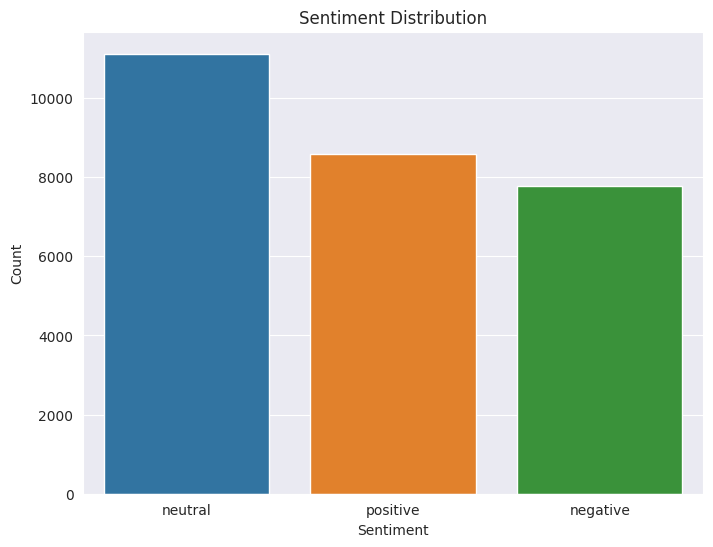

In [16]:
sentiment_counts = train['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

To understand how good the predictions are, we can plot the confusion matrix:

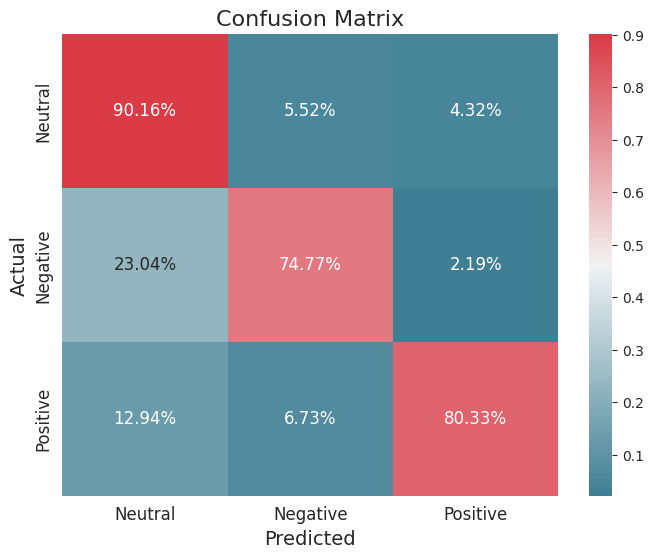

In [17]:
# Build confusion matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
conf_matrix = pd.DataFrame(matrix, index=['Neutral', 'Negative', 'Positive'], columns=['Neutral', 'Negative', 'Positive'])

# Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1).values[:, np.newaxis]

plt.figure(figsize=(8, 6))  # Adjust the figsize as per your preference

# Customize color map
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot the heatmap
sns.heatmap(conf_matrix, annot=True, fmt=".2%", cmap=cmap, annot_kws={"size": 12})

# Add labels and title
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Adjust the tick labels' size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.show()

# Conclusion

Based on the obtained heatmap, certain observations can be made regarding the classification performance:

- When considering the reviews that were **originally positive**, an approximate 80% were accurately identified as positive by the model.
- For **negative reviews**, around 75% were correctly classified as negative.
- In terms of **neutral reviews**, the model achieved an accuracy of about 90%.

It must be noted that the model was trained over only 10 epochs due to computational limitations, increasing the number of epochs may increase the overall accuracy of the model. Although these outcomes demonstrate a respectable baseline performance, there is still potential for improvement. In a business context, achieving higher accuracy is often a priority. Typically, a target accuracy of roughly 95% is deemed feasible for relatively straightforward cases. By acknowledging these baseline findings, we can strive to develop more sophisticated models and enhance the classification process for better performance. This may involve employing various techniques like refining the model architecture, exploring alternate algorithms, optimizing hyperparameters, or utilizing more advanced natural language processing (NLP) methods.

Ultimately, the goal is to elevate the model's accuracy to meet or surpass the desired threshold, ensuring more dependable sentiment classification in real-world business scenarios.

# Bonus

The model can also be tested against an arbitrary input text using the following function:

In [18]:
def pred_sent(text: str):
    sentiment = ['Neutral','Negative','Positive']
    sequence = tokenizer.texts_to_sequences([text])
    test = pad_sequences(sequence, maxlen=max_len)
    return sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

The syntax is as follows:

In [19]:
# Run a prediction
input_text = "I really enjoyed the course about Neural Networks, I found it very interesting."

print("\nSentence:", input_text, "\nSentiment:", pred_sent(input_text))

1/1 [==============================] - 0s 49ms/step

Sentence: I really enjoyed the course about Neural Networks, I found it very interesting. 
Sentiment: Positive
